# poor/rich neighborhoods and social ties
(sandorjuhasz & kovacsa shared notebook)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.gridspec as gridspec
%matplotlib inline

import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString

import json
import time
import itertools
from copy import deepcopy

/Users/adamkovacs/env/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Fig3 - barplots

In [3]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50_adam.csv.gz")

# clustering data
#clust_tab = pd.read_csv("../data/avg_clust_tab_top50.csv.gz")
clust_tab = pd.read_csv("../data/clust_tab_top50_adam.csv.gz")
input_data = pd.merge(clust_tab, degree_tab, on="user_id", how="left")

# support data
supp_tab = pd.read_csv("../data/supp_tab_top50_adam.csv.gz")
input_data = pd.merge(supp_tab, input_data, on="user_id", how="left")

In [11]:
clust_tab = clust_tab.merge(degree_tab[['user_id', 'poor','short_name']], on = "user_id", how = "left")

In [12]:
supp_tab = supp_tab.merge(degree_tab[['user_id', 'short_name', 'poor']], on = "user_id", how = "left")

In [5]:
# user count per cbsa
users_cbsa = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()

metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[users_cbsa["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

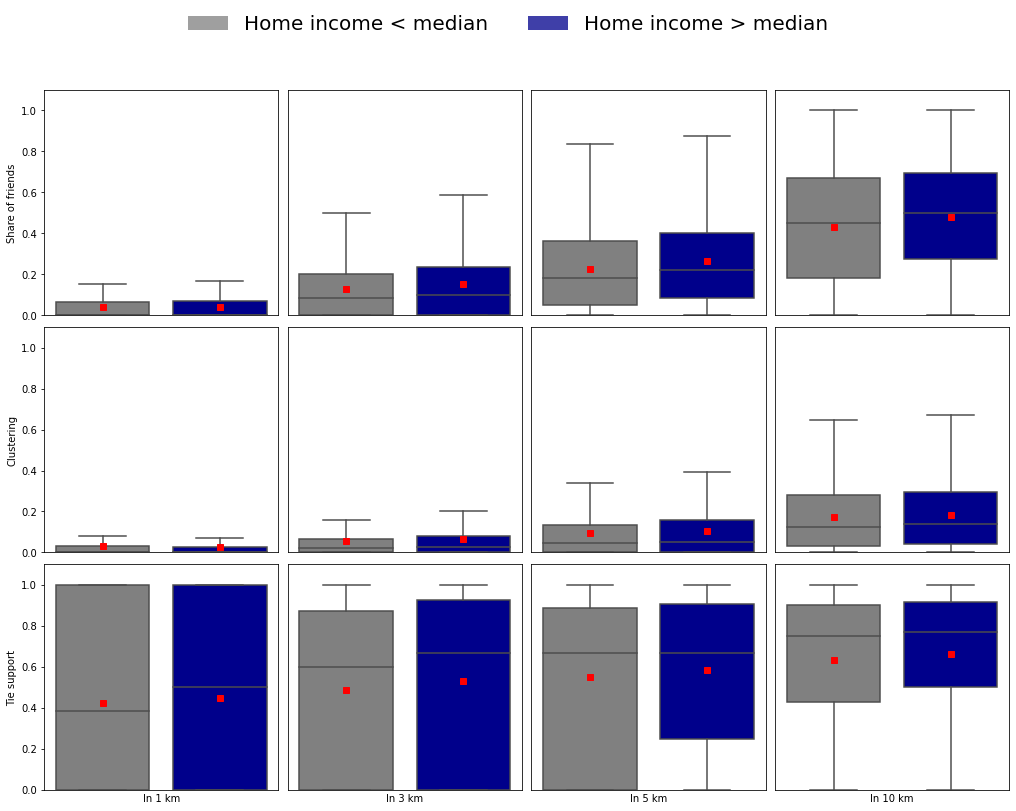

In [13]:
fig, ax = plt.subplots(3, 4, figsize = (14, 10), constrained_layout=True, sharex=True)

dists_share = ["dcum1000_share", "dcum3000_share", "dcum5000_share", "dcum10000_share"]

names = ["In 1 km", "In 3 km", "In 5 km", "In 10 km"]

my_colours = (["grey", "darkblue"], ["darkblue", "grey"])

for idx, dist in enumerate(dists_share):
    sns.boxplot(x = 'poor', y = dist, data=degree_tab, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"red", "markeredgecolor":"red"},\
            showfliers=False, ax=ax[0,idx])
    ax[0,idx].set_ylim([0, 1.1])
    ax[0,idx].set_xticklabels(['', ""])
    ax[0,idx].set_xlabel(names[idx])
    ax[0,idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[0,idx].xaxis.label.set_visible(False)
    ax[0,idx].set_ylabel("Share of friends")
    if idx > 0:
        ax[0,idx].yaxis.label.set_visible(False)
        ax[0,idx].yaxis.set_visible(False)

    boxes = ax[0,idx].findobj(matplotlib.patches.PathPatch)
    for color, box in zip(my_colours, boxes):
        box.set_facecolor(color[0])

dists_clust = ["clust1000", "clust3000", "clust5000", "clust10000"]
        
for idx, dist in enumerate(dists_clust):
    sns.boxplot(x = 'poor', y = dist, data=clust_tab, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"red", "markeredgecolor":"red"},\
            showfliers=False, ax=ax[1,idx])
    ax[1,idx].set_ylim([0, 1.1])
    ax[1,idx].set_xticklabels(['', ""])
    ax[1,idx].set_xlabel(names[idx])
    ax[1,idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[1,idx].set_ylabel("Clustering")
    ax[1,idx].xaxis.label.set_visible(False)
    if idx > 0:
        ax[1,idx].yaxis.label.set_visible(False)
        ax[1,idx].yaxis.set_visible(False)

    boxes = ax[1,idx].findobj(matplotlib.patches.PathPatch)
    for color, box in zip(my_colours, boxes):
        box.set_facecolor(color[0])

dists_supp = ["support1000", "support3000", "support5000", "support10000"]
        
for idx, dist in enumerate(dists_supp):
    sns.boxplot(x = 'poor', y = dist, data=supp_tab, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"red", "markeredgecolor":"red"},\
            showfliers=False, ax=ax[2,idx])
    ax[2,idx].set_ylim([0, 1.1])
    ax[2,idx].set_xticklabels(['', ""])
    ax[2,idx].set_xlabel(names[idx])
    ax[2,idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[2,idx].set_ylabel("Tie support")
    if idx > 0:
        ax[2,idx].yaxis.label.set_visible(False)
        ax[2,idx].yaxis.set_visible(False)

    boxes = ax[2,idx].findobj(matplotlib.patches.PathPatch)
    for color, box in zip(my_colours, boxes):
        box.set_facecolor(color[0])
        
        

# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.125),
    ncol=2, frameon=False, fontsize=20)

#plt.savefig('../fig/boxplot.png',density=300,bbox_inches='tight')

In [68]:
degree_poor = degree_tab[degree_tab["poor"]==1]

In [69]:
degree_poor["short_name"] = degree_poor["short_name"].replace('Louisville/Jefferson County','Louisville')

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/4029602435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  degree_poor["short_name"] = degree_poor["short_name"].replace('Louisville/Jefferson County','Louisville')


/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/4021498415.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/box_share_poor.png',density=300,bbox_inches='tight')


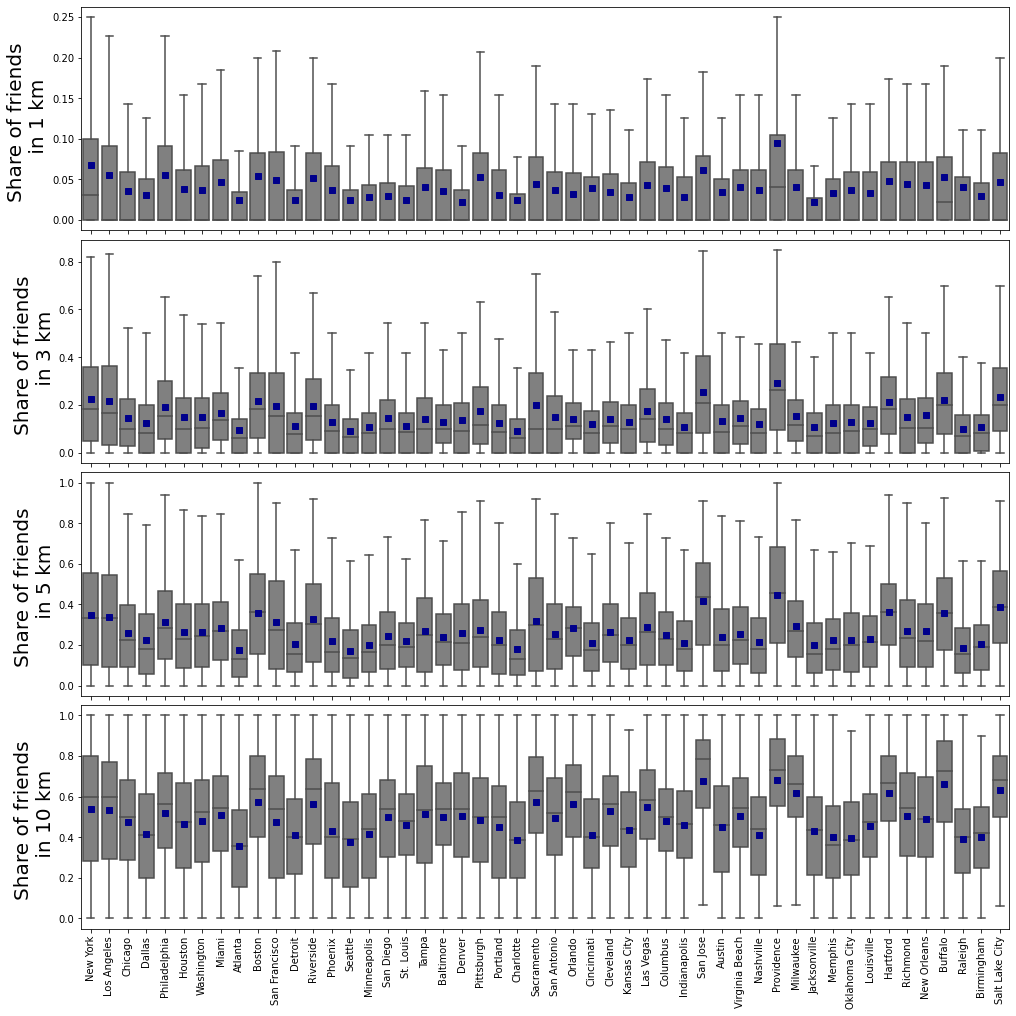

In [75]:
fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)

sns.boxplot(x= "short_name", y="dcum1000_share", data=degree_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])

ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel('Share of friends \n in 1 km', size=20)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="dcum3000_share", data=degree_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])

ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel('Share of friends \n in 3 km', size=20)
#ax[1].set_ylim([0, 1])
#ax[1].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="dcum5000_share", data=degree_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])

ax[2].xaxis.label.set_visible(False)
ax[2].set_ylabel('Share of friends \n in 5 km', size=20)
#ax[2].set_ylim([0, 1.1])
#ax[2].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="dcum10000_share", data=degree_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[3], order = metrodata["short_name"])

ax[3].set_ylabel('Share of friends \n in 10 km', size=20)
plt.xticks(rotation=90)
ax[3].xaxis.label.set_visible(False)
#ax[3].set_ylim([0, 1.1])
#ax[3].set_yticks(np.linspace(0,1,6))

#fig.text(0.00001, 0.63, 'Share of friends', ha='center', va='center', rotation='vertical', size = 20)

plt.savefig('../fig/box_share_poor.png',density=300,bbox_inches='tight')

In [71]:
degree_rich = degree_tab[degree_tab["poor"]==0]

In [72]:
degree_rich["short_name"] = degree_rich["short_name"].replace('Louisville/Jefferson County','Louisville')

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/3417204007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  degree_rich["short_name"] = degree_rich["short_name"].replace('Louisville/Jefferson County','Louisville')


/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/3267980961.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/box_share_rich.png',density=300,bbox_inches='tight')


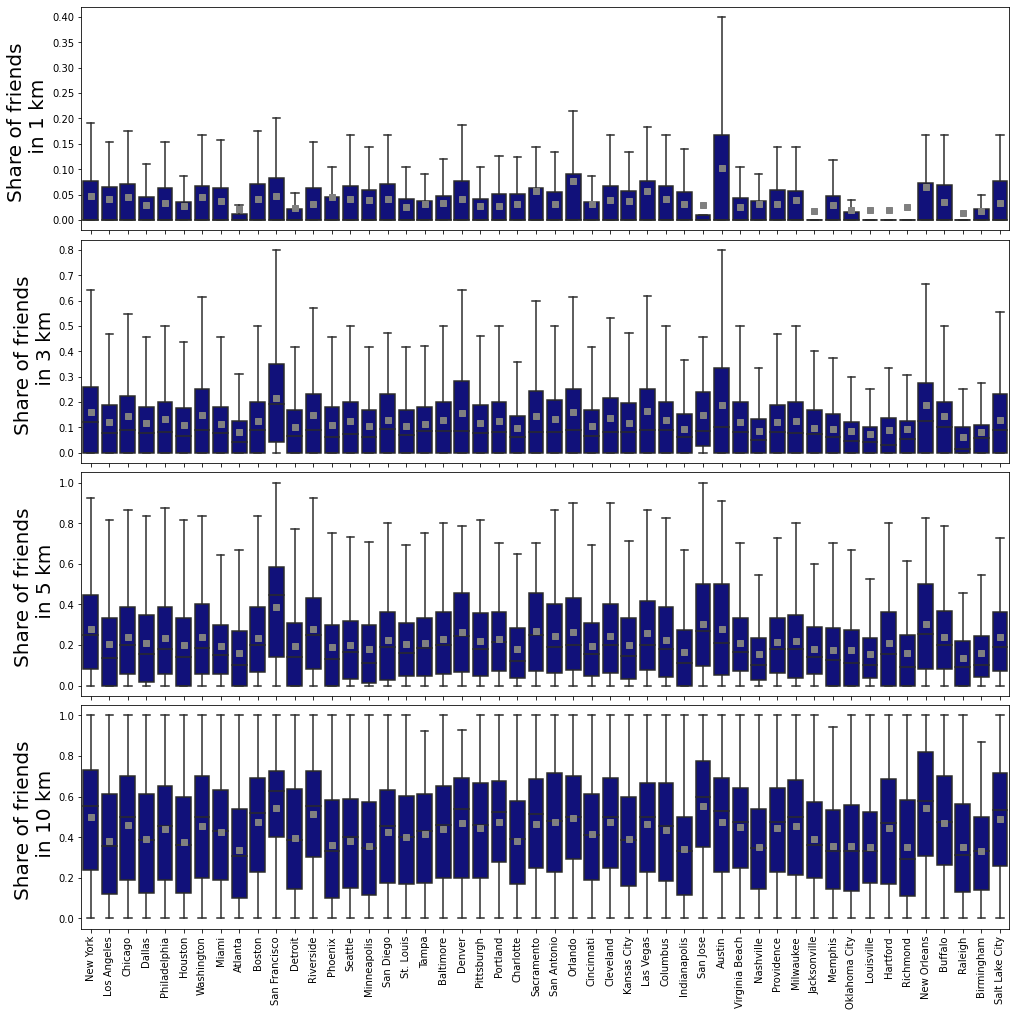

In [73]:
fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)

sns.boxplot(x= "short_name", y="dcum1000_share", data=degree_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])

ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel('Share of friends \n in 1 km', size=20)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="dcum3000_share", data=degree_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])

ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel('Share of friends \n in 3 km', size=20)
#ax[1].set_ylim([0, 1])
#ax[1].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="dcum5000_share", data=degree_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])

ax[2].xaxis.label.set_visible(False)
ax[2].set_ylabel('Share of friends \n in 5 km', size=20)
#ax[2].set_ylim([0, 1.1])
#ax[2].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="dcum10000_share", data=degree_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[3], order = metrodata["short_name"])

ax[3].set_ylabel('Share of friends \n in 10 km', size=20)
plt.xticks(rotation=90)
ax[3].xaxis.label.set_visible(False)
#ax[3].set_ylim([0, 1.1])
#ax[3].set_yticks(np.linspace(0,1,6))

#fig.text(0.00001, 0.63, 'Share of friends', ha='center', va='center', rotation='vertical', size = 20)

plt.savefig('../fig/box_share_rich.png',density=300,bbox_inches='tight')

In [76]:
clust_poor = clust_tab[clust_tab["poor"]==1]

In [77]:
clust_poor["short_name"] = clust_poor["short_name"].replace('Louisville/Jefferson County','Louisville')

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/3352727294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_poor["short_name"] = clust_poor["short_name"].replace('Louisville/Jefferson County','Louisville')


/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/248403272.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/box_clust_poor.png',density=300,bbox_inches='tight')


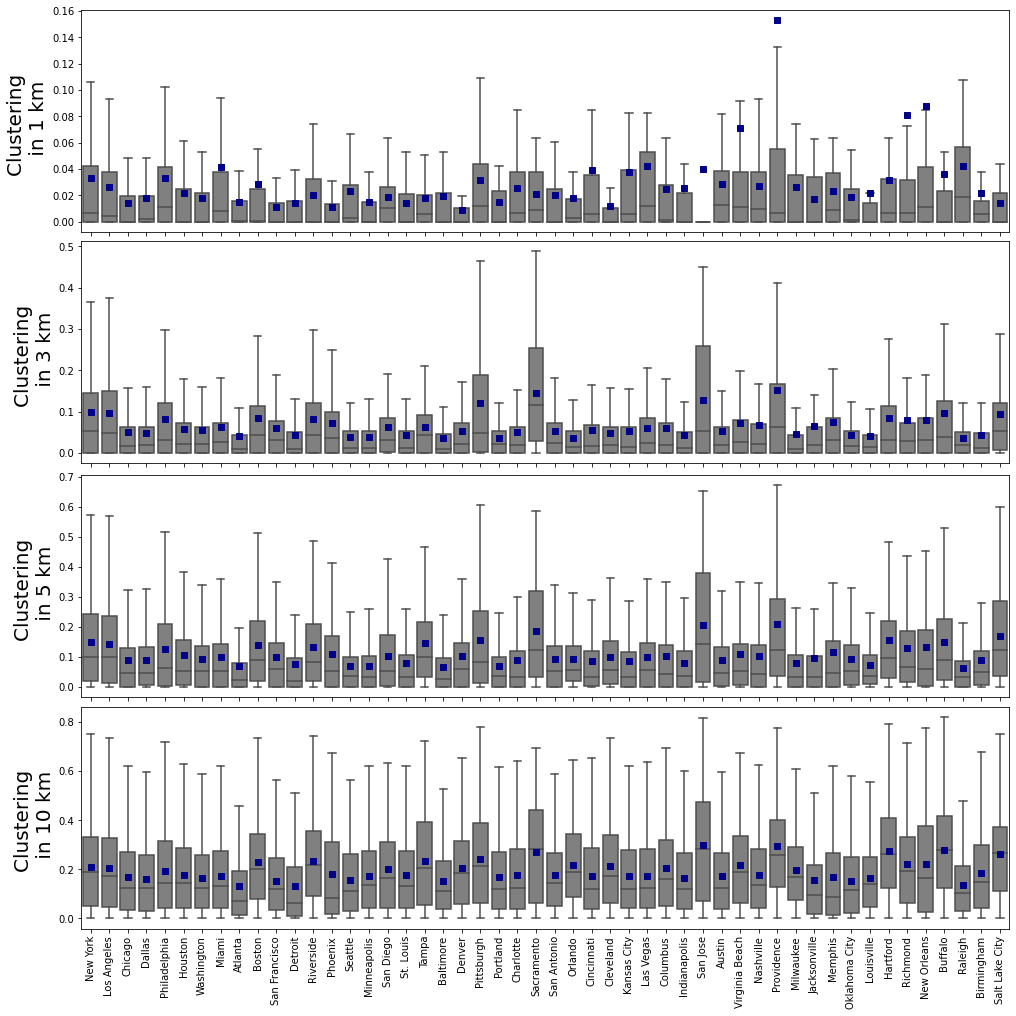

In [78]:
fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)

sns.boxplot(x= "short_name", y="clust1000", data=clust_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])

ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel('Clustering \n in 1 km', size=20)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="clust3000", data=clust_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])

ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel('Clustering \n in 3 km', size=20)
#ax[1].set_ylim([0, 1])
#ax[1].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="clust5000", data=clust_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])

ax[2].xaxis.label.set_visible(False)
ax[2].set_ylabel('Clustering \n in 5 km', size=20)
#ax[2].set_ylim([0, 1.1])
#ax[2].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="clust10000", data=clust_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[3], order = metrodata["short_name"])

ax[3].set_ylabel('Clustering \n in 10 km', size=20)
plt.xticks(rotation=90)
ax[3].xaxis.label.set_visible(False)
#ax[3].set_ylim([0, 1.1])
#ax[3].set_yticks(np.linspace(0,1,6))

#fig.text(0.00001, 0.63, 'Share of friends', ha='center', va='center', rotation='vertical', size = 20)

#plt.show()

plt.savefig('../fig/box_clust_poor.png',density=300,bbox_inches='tight')

In [79]:
clust_rich = clust_tab[clust_tab["poor"]==0]

In [80]:
clust_rich["short_name"] = clust_rich["short_name"].replace('Louisville/Jefferson County','Louisville')

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/3563253166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_rich["short_name"] = clust_rich["short_name"].replace('Louisville/Jefferson County','Louisville')


/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/2549565040.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/box_clust_rich.png',density=300,bbox_inches='tight')


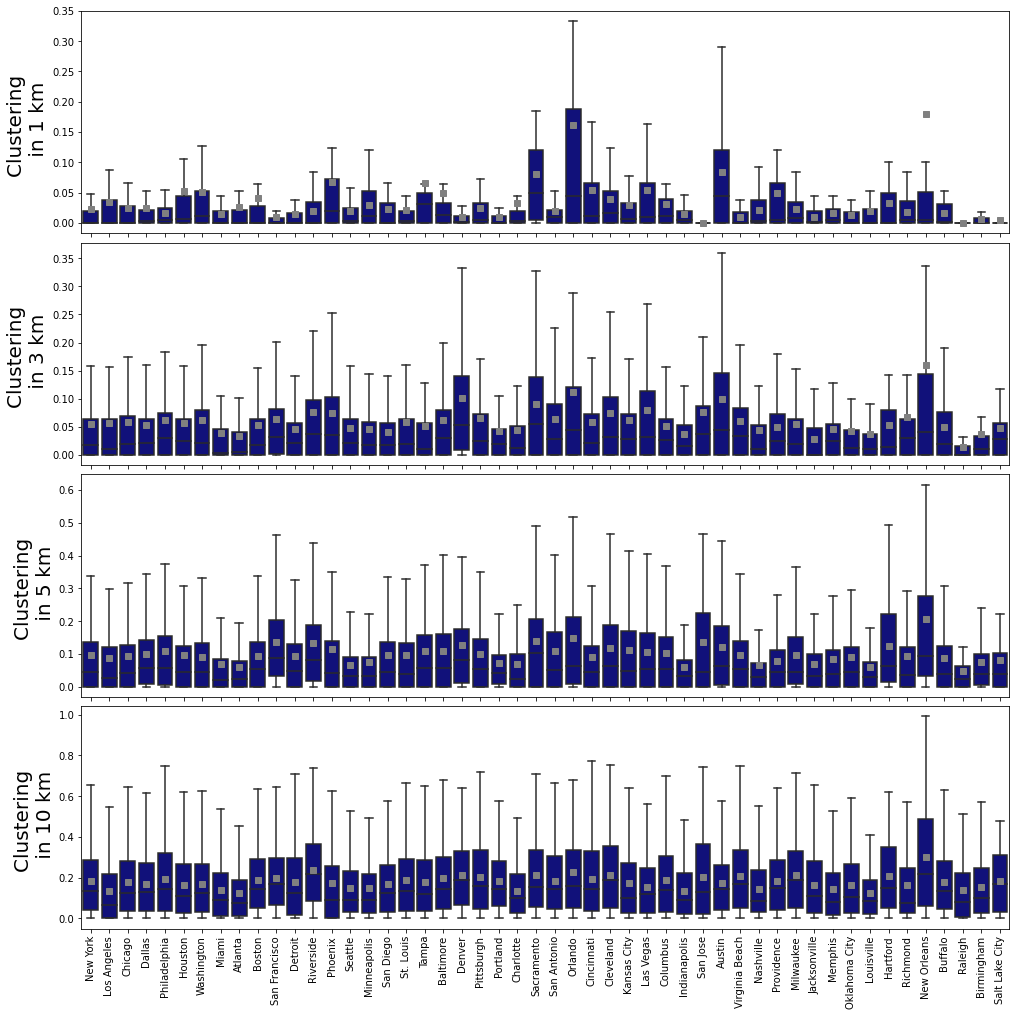

In [81]:
fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)

sns.boxplot(x= "short_name", y="clust1000", data=clust_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])

ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel('Clustering \n in 1 km', size=20)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="clust3000", data=clust_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])

ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel('Clustering \n in 3 km', size=20)
#ax[1].set_ylim([0, 1])
#ax[1].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="clust5000", data=clust_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])

ax[2].xaxis.label.set_visible(False)
ax[2].set_ylabel('Clustering \n in 5 km', size=20)
#ax[2].set_ylim([0, 1.1])
#ax[2].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="clust10000", data=clust_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[3], order = metrodata["short_name"])

ax[3].set_ylabel('Clustering \n in 10 km', size=20)
plt.xticks(rotation=90)
ax[3].xaxis.label.set_visible(False)
#ax[3].set_ylim([0, 1.1])
#ax[3].set_yticks(np.linspace(0,1,6))

#fig.text(0.00001, 0.63, 'Share of friends', ha='center', va='center', rotation='vertical', size = 20)

#plt.show()

plt.savefig('../fig/box_clust_rich.png',density=300,bbox_inches='tight')

In [82]:
supp_poor = supp_tab[supp_tab["poor"]==1]

In [83]:
supp_poor["short_name"] = supp_poor["short_name"].replace('Louisville/Jefferson County','Louisville')

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/1522203494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_poor["short_name"] = supp_poor["short_name"].replace('Louisville/Jefferson County','Louisville')


/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/3996275659.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/box_supp_poor.png',density=300,bbox_inches='tight')


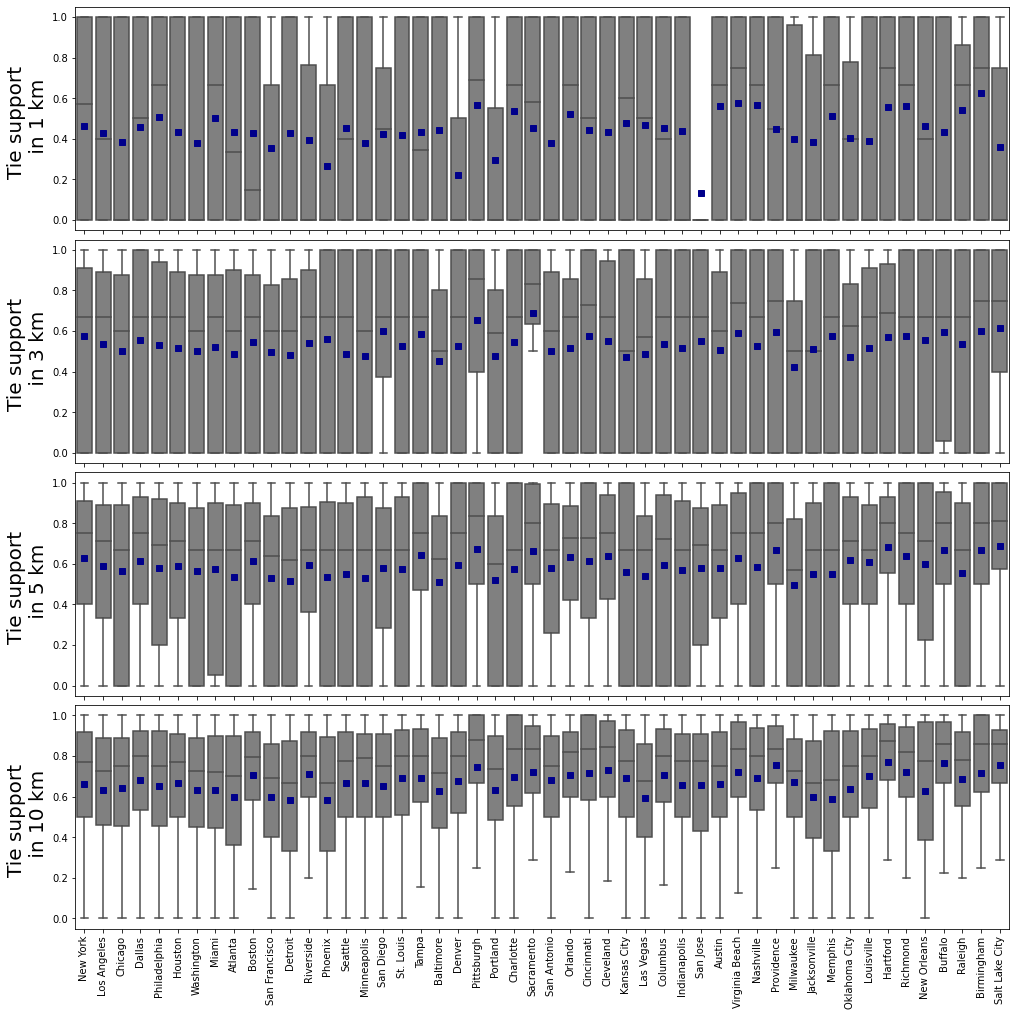

In [84]:
fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)

sns.boxplot(x= "short_name", y="support1000", data=supp_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])

ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel('Tie support \n in 1 km', size=20)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="support3000", data=supp_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])

ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel('Tie support \n in 3 km', size=20)
#ax[1].set_ylim([0, 1])
#ax[1].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="support5000", data=supp_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])

ax[2].xaxis.label.set_visible(False)
ax[2].set_ylabel('Tie support \n in 5 km', size=20)
#ax[2].set_ylim([0, 1.1])
#ax[2].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="support10000", data=supp_poor, color="grey",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"darkblue", "markeredgecolor":"darkblue"},\
            showfliers=False, ax=ax[3], order = metrodata["short_name"])

ax[3].set_ylabel('Tie support \n in 10 km', size=20)
plt.xticks(rotation=90)
ax[3].xaxis.label.set_visible(False)
#ax[3].set_ylim([0, 1.1])
#ax[3].set_yticks(np.linspace(0,1,6))

#fig.text(0.00001, 0.63, 'Share of friends', ha='center', va='center', rotation='vertical', size = 20)

#plt.show()

plt.savefig('../fig/box_supp_poor.png',density=300,bbox_inches='tight')

In [85]:
supp_rich = supp_tab[supp_tab["poor"]==0]

In [86]:
supp_rich["short_name"] = supp_rich["short_name"].replace('Louisville/Jefferson County','Louisville')

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/3195153349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_rich["short_name"] = supp_rich["short_name"].replace('Louisville/Jefferson County','Louisville')


/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_6045/2802398004.py:45: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/box_supp_rich.png',density=300,bbox_inches='tight')


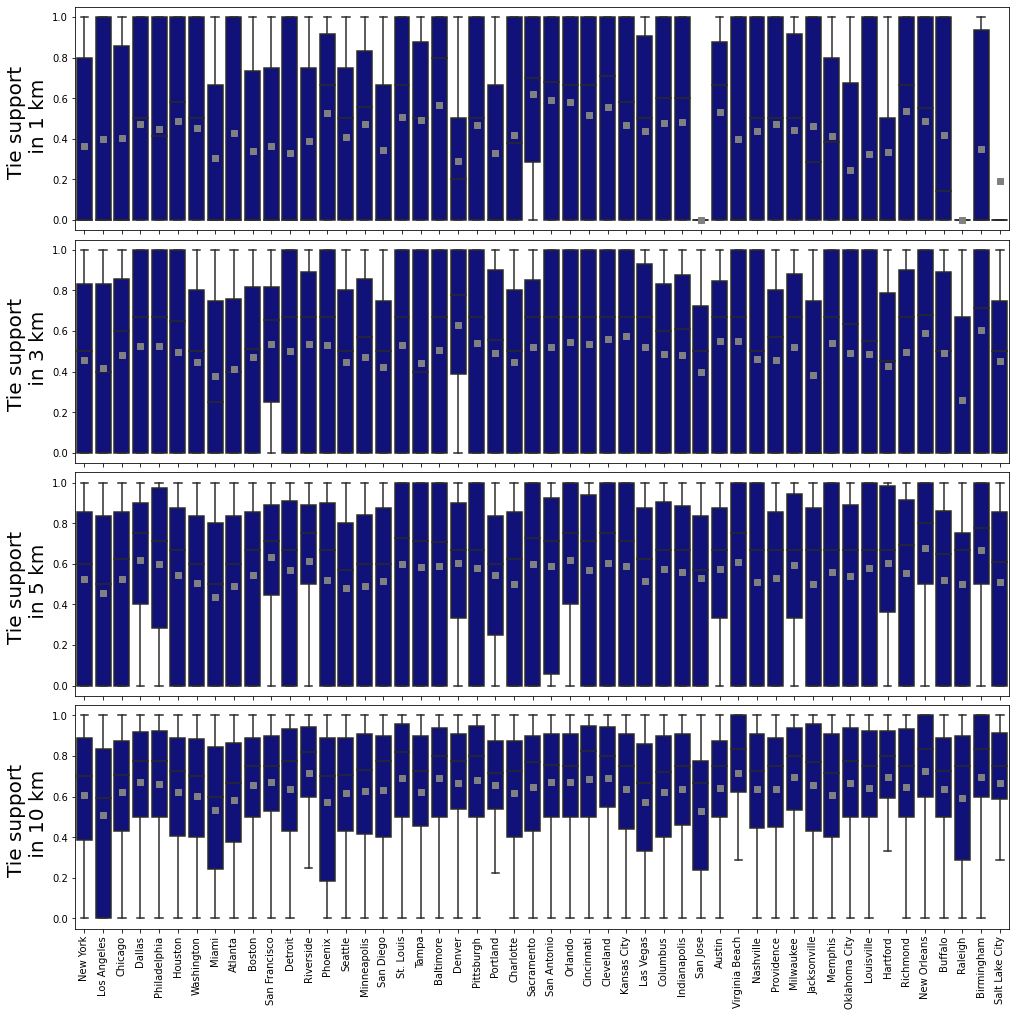

In [87]:
fig, ax = plt.subplots(4, 1, figsize = (14, 14), constrained_layout=True, sharex=True)


sns.boxplot(x= "short_name", y="support1000", data=supp_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[0], order = metrodata["short_name"])

ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel('Tie support \n in 1 km', size=20)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="support3000", data=supp_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[1], order = metrodata["short_name"])

ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel('Tie support \n in 3 km', size=20)
#ax[1].set_ylim([0, 1])
#ax[1].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="support5000", data=supp_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[2], order = metrodata["short_name"])

ax[2].xaxis.label.set_visible(False)
ax[2].set_ylabel('Tie support \n in 5 km', size=20)
#ax[2].set_ylim([0, 1.1])
#ax[2].set_yticks(np.linspace(0,1,6))

sns.boxplot(x= "short_name", y="support10000", data=supp_rich, color="darkblue",\
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"grey", "markeredgecolor":"grey"},\
            showfliers=False, ax=ax[3], order = metrodata["short_name"])

ax[3].set_ylabel('Tie support \n in 10 km', size=20)
plt.xticks(rotation=90)
ax[3].xaxis.label.set_visible(False)
#ax[3].set_ylim([0, 1.1])
#ax[3].set_yticks(np.linspace(0,1,6))

#fig.text(0.00001, 0.63, 'Share of friends', ha='center', va='center', rotation='vertical', size = 20)

#plt.show()

plt.savefig('../fig/box_supp_rich.png',density=300,bbox_inches='tight')

In [54]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [55]:
# data for Fig3 - degree
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]
type = list(["poor"] *4) + list(["rich"] *4)


# data for Fig3
pr = {"poor" : 1, "rich" : 0}


# loop to construct the dataframe
for t in pr:

    # name the necessary columns
    col_filter = ['dcum1000_share', 'dcum3000_share', 'dcum5000_share', 'dcum10000_share']

    # table and columns to use
    temp = input_data[input_data["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]


    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 4000)   # change repetition HERE
        means.append(np.mean(bootstrap_mean))
        lower.append(np.percentile(bootstrap_mean, 2.5))
        upper.append(np.percentile(bootstrap_mean, 97.5))
        error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
        error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_degree = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [56]:
result_degree

,dist,mean,error_lower,error_upper,lower,upper,type
0,dcum1000_share,0.040626,0.000595,0.000612,0.040030,0.041237,poor
1,dcum3000_share,0.153465,0.001384,0.001448,0.152080,0.154913,poor
2,dcum5000_share,0.263664,0.001872,0.001894,0.261792,0.265558,poor
3,dcum10000_share,0.477860,0.002337,0.002390,0.475522,0.480249,poor
4,dcum1000_share,0.037825,0.000729,0.000722,0.037096,0.038547,rich
5,dcum3000_share,0.128530,0.001500,0.001500,0.127030,0.130030,rich
6,dcum5000_share,0.226141,0.002124,0.002139,0.224017,0.228280,rich
7,dcum10000_share,0.430497,0.003023,0.002913,0.427474,0.433411,rich


In [57]:
# data for Fig3 - clustering
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]
type = list(["poor"] *4) + list(["rich"] *4)


# data for Fig3
pr = {"poor" : 1, "rich" : 0}


# loop to construct the dataframe
for t in pr:

    # name the necessary columns
    col_filter = ['clust1000', 'clust3000', 'clust5000', 'clust10000']

    # table and columns to use
    temp = input_data[input_data["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]


    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 4000)   # change repetition HERE
        means.append(np.mean(bootstrap_mean))
        lower.append(np.percentile(bootstrap_mean, 2.5))
        upper.append(np.percentile(bootstrap_mean, 97.5))
        error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
        error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_clust = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [58]:
# data for Fig3 - support
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]
type = list(["poor"] *4) + list(["rich"] *4)


# data for Fig3
pr = {"poor" : 1, "rich" : 0}


# loop to construct the dataframe
for t in pr:

    # name the necessary columns
    col_filter = ['support1000', 'support3000', 'support5000', 'support10000']

    # table and columns to use
    temp = input_data[input_data["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]


    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 4000)   # change repetition HERE
        means.append(np.mean(bootstrap_mean))
        lower.append(np.percentile(bootstrap_mean, 2.5))
        upper.append(np.percentile(bootstrap_mean, 97.5))
        error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
        error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_support = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

/var/folders/2p/vpm_xjfn7f1_8ytrmxkbl78w0000gn/T/ipykernel_75006/2179684727.py:69: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/mf3_adam.png',density=300,bbox_inches='tight')


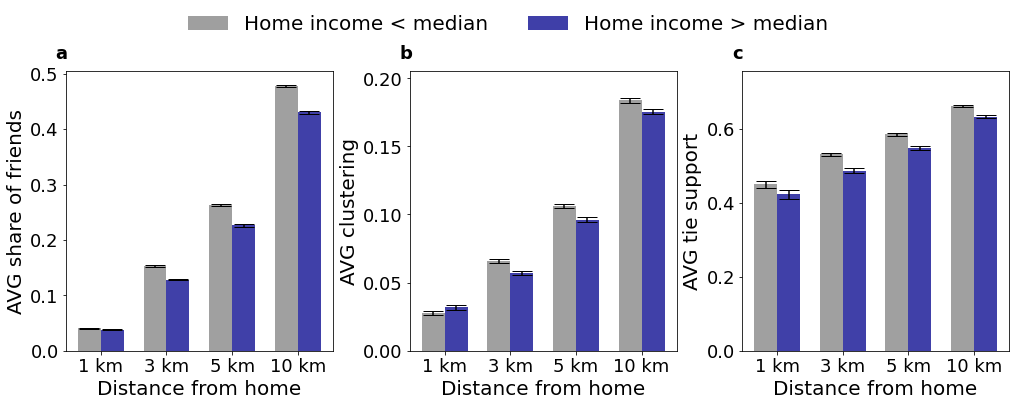

In [59]:
# plot -- Fig 3 a-b-c
# fig,ax = plt.subplots(1,3,figsize=(29,6), sharex=True)
fig, ax = plt.subplots(1, 3, figsize = (14, 5), constrained_layout=True, sharex=True)
plt.rcParams['font.size']=18

titles = ['1 km', '3 km', '5 km', '10 km']
                                                                                                                    
# color of bars
colorsList = ["grey", "darkblue"]

# part a
X = np.arange(4)
bar_width = 0.35
a_poor = result_degree[result_degree["type"]=="poor"]
a_rich = result_degree[result_degree["type"]=="rich"]
rects1 = ax[0].bar(X, a_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [a_poor["error_lower"], a_poor["error_upper"]], capsize = 10, alpha=0.75)
rects2 = ax[0].bar(X + bar_width, a_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [a_rich["error_lower"], a_rich["error_upper"]], capsize = 10, alpha=0.75) 
ax[0].set_ylabel('AVG share of friends', size=20)
ax[0].set_xlabel(xlabel='Distance from home', size=20)
ax[0].set_xticks(X + bar_width/2)
#ax[0].set_xticklabels(['1 km','3 km' '5 km', '10 km'])



# part b
X = np.arange(4)
bar_width = 0.35
b_poor = result_clust[result_clust["type"]=="poor"]
b_rich = result_clust[result_clust["type"]=="rich"]
rects1 = ax[1].bar(X, b_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [b_poor["error_lower"], b_poor["error_upper"]], capsize = 10, alpha=0.75)
rects2 = ax[1].bar(X + bar_width, b_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [b_rich["error_lower"], b_rich["error_upper"]], capsize = 10, alpha=0.75) 
ax[1].set_ylabel('AVG clustering', size=20)
ax[1].set_xlabel(xlabel='Distance from home', size=20)
ax[1].set_xticks(X + bar_width/2)
ax[1].set_xticklabels(['1 km','3 km', '5 km', '10 km'])
ax[1].set_ylim([0, 0.205])


# part c
X = np.arange(4)
bar_width = 0.35
c_poor = result_support[result_support["type"]=="poor"]
c_rich = result_support[result_support["type"]=="rich"]
rects1 = ax[2].bar(X, c_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [c_poor["error_lower"], c_poor["error_upper"]], capsize = 10, alpha=0.75)
rects2 = ax[2].bar(X + bar_width, c_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [c_rich["error_lower"], c_rich["error_upper"]], capsize = 10, alpha=0.75) 
ax[2].set_ylabel('AVG tie support', size=20)
ax[2].set_xlabel(xlabel='Distance from home', size=20)
ax[2].set_xticks(X + bar_width/2)
ax[2].set_xticklabels(['1 km','3 km', '5 km', '10 km'])
ax[2].set_ylim([0, 0.755])




# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.125),
    ncol=2, frameon=False, fontsize=20)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')


#plt.show()
plt.savefig('../fig/mf3_adam.png',density=300,bbox_inches='tight')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

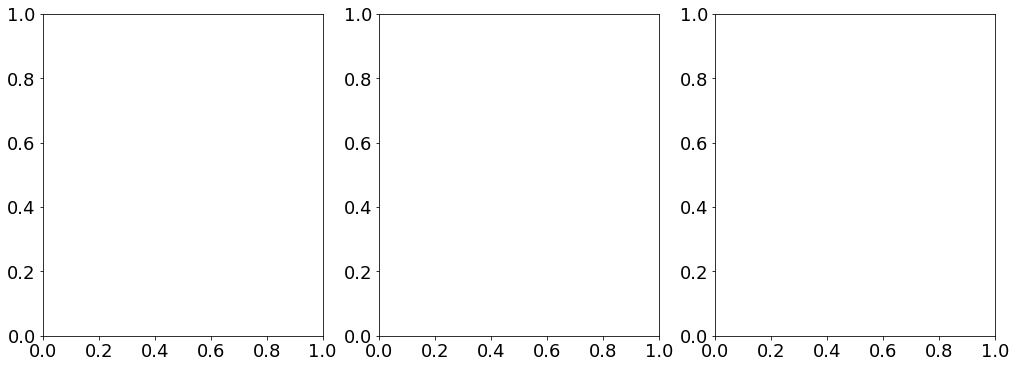

In [60]:
# plot -- Fig 3 a-b-c
# fig,ax = plt.subplots(1,3,figsize=(29,6), sharex=True)
fig, ax = plt.subplots(1, 3, figsize = (14, 5), constrained_layout=True, sharex=True)
plt.rcParams['font.size']=18

titles = ['1 km', '5 km', '10 km']
                                                                                                                    
# color of bars
colorsList = ["grey", "darkblue"]

# part a
X = np.arange(3)
bar_width = 0.35
a_poor = result_degree[result_degree["type"]=="poor"]
a_rich = result_degree[result_degree["type"]=="rich"]
rects1 = ax[0].bar(X, a_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [a_poor["error_lower"], a_poor["error_upper"]], capsize = 10, alpha=0.75)
rects2 = ax[0].bar(X + bar_width, a_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [a_rich["error_lower"], a_rich["error_upper"]], capsize = 10, alpha=0.75) 
ax[0].set_ylabel('AVG share of friends', size=20)
ax[0].set_xlabel(xlabel='Distance from home', size=20)
ax[0].set_xticks(X + bar_width/2)
ax[0].set_xticklabels(['1 km', '5 km', '10 km'])



# part b
X = np.arange(3)
bar_width = 0.35
b_poor = result_clust[result_clust["type"]=="poor"]
b_rich = result_clust[result_clust["type"]=="rich"]
rects1 = ax[1].bar(X, b_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [b_poor["error_lower"], b_poor["error_upper"]], capsize = 10, alpha=0.75)
rects2 = ax[1].bar(X + bar_width, b_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [b_rich["error_lower"], b_rich["error_upper"]], capsize = 10, alpha=0.75) 
ax[1].set_ylabel('AVG clustering', size=20)
ax[1].set_xlabel(xlabel='Distance from home', size=20)
ax[1].set_xticks(X + bar_width/2)
ax[1].set_xticklabels(['1 km', '5 km', '10 km'])
ax[1].set_ylim([0, 0.205])


# part c
X = np.arange(3)
bar_width = 0.35
c_poor = result_support[result_support["type"]=="poor"]
c_rich = result_support[result_support["type"]=="rich"]
rects1 = ax[2].bar(X, c_poor["mean"], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [c_poor["error_lower"], c_poor["error_upper"]], capsize = 10, alpha=0.75)
rects2 = ax[2].bar(X + bar_width, c_rich["mean"], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [c_rich["error_lower"], c_rich["error_upper"]], capsize = 10, alpha=0.75) 
ax[2].set_ylabel('AVG tie support', size=20)
ax[2].set_xlabel(xlabel='Distance from home', size=20)
ax[2].set_xticks(X + bar_width/2)
ax[2].set_xticklabels(['1 km', '5 km', '10 km'])
ax[2].set_ylim([0, 0.755])




# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.125),
    ncol=2, frameon=False, fontsize=20)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')


plt.show()
# plt.savefig('../fig/mf3.png',density=300,bbox_inches='tight')

## Fig 4 - lollipop

In [2]:
# METRODATA

metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").reset_index().sort_values(by="CENSUS2010POP", ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank", "CBSA":"cbsacode", "NAME":"name", "CENSUS2010POP":"population"}, axis=1, inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.iloc[:50,] # keep the top50 ONLY
# metrodata = metrodata.reset_index()

In [3]:
# degree data
degree_tab = pd.read_csv("../data/degree_tab_top50_adam.csv.gz")

# average degree by group
metrodata["poor_degree"] = metrodata.index.map(degree_tab[degree_tab["poor"]==1].groupby("cbsacode")["dcum10000_share"].agg("mean").to_dict())
metrodata["rich_degree"] = metrodata.index.map(degree_tab[degree_tab["rich"]==1].groupby("cbsacode")["dcum10000_share"].agg("mean").to_dict())

In [4]:
# clustering data
clust_tab = pd.read_csv("../data/clust_tab_top50.csv.gz")
clust_tab = pd.merge(clust_tab, degree_tab, on="user_id", how="left")

# average degree by group
metrodata["poor_clust"] = metrodata.index.map(clust_tab[clust_tab["poor"]==1].groupby("cbsacode")["clust10000"].agg("mean").to_dict())
metrodata["rich_clust"] = metrodata.index.map(clust_tab[clust_tab["rich"]==1].groupby("cbsacode")["clust10000"].agg("mean").to_dict())

In [5]:
# clustering data
supp_tab = pd.read_csv("../data/supp_tab_top50.csv.gz")
supp_tab = pd.merge(supp_tab, degree_tab, on="user_id", how="left")

# average degree by group
metrodata["poor_supp"] = metrodata.index.map(supp_tab[supp_tab["poor"]==1].groupby("cbsacode")["support10000"].agg("mean").to_dict())
metrodata["rich_supp"] = metrodata.index.map(supp_tab[supp_tab["rich"]==1].groupby("cbsacode")["support10000"].agg("mean").to_dict())

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later


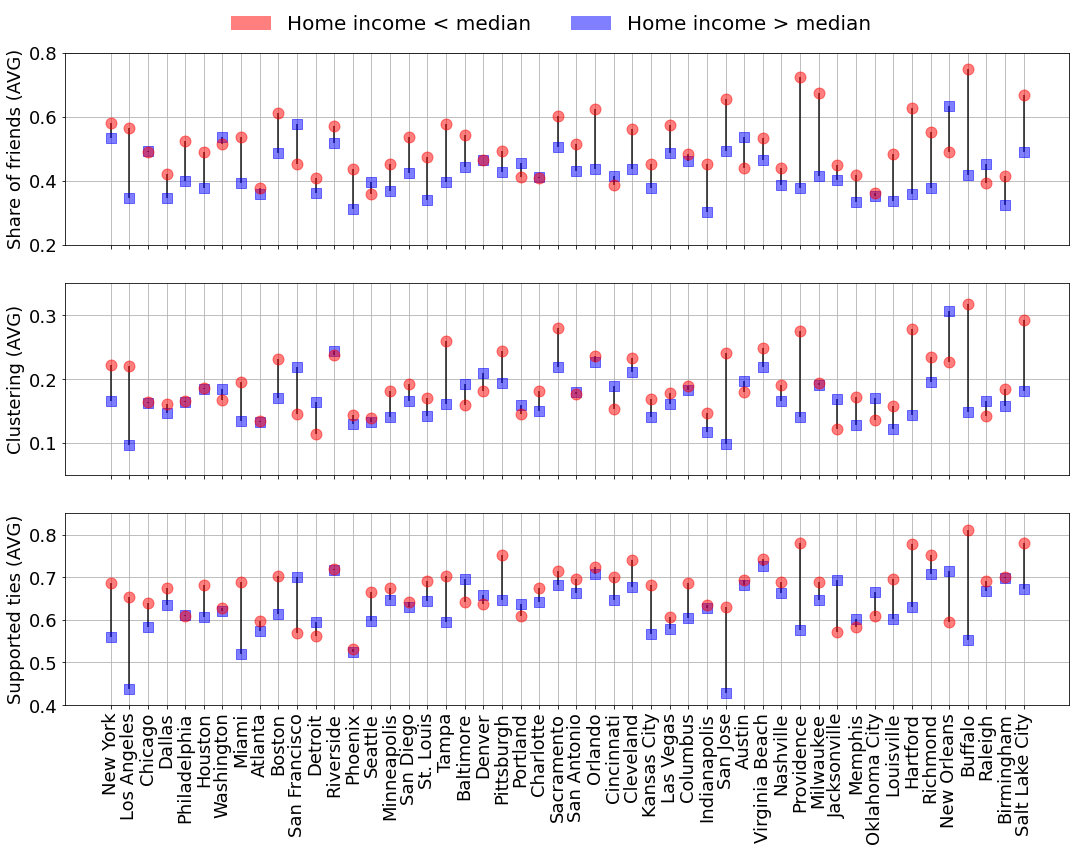

In [16]:
# plot 2
fig,ax = plt.subplots(3,1,figsize=(18,12), sharex=True)
plt.rcParams['font.size']=18

#(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)
# avg share of friends -- cummulative
ax[0].vlines(x=metrodata['short_name'], ymin=metrodata['poor_degree'], ymax=metrodata['rich_degree'], color='black', alpha=0.9)
ax[0].scatter(metrodata['short_name'], metrodata['rich_degree'], color=(0.0, 0.0, 1.0), marker='s', s=120, alpha=0.5, zorder=2)
ax[0].scatter(metrodata['short_name'], metrodata['poor_degree'], color=(1.0, 0.0, 0.0), marker='o', s=120, alpha=0.5, zorder=2)
ax[0].set_xticklabels(labels="", rotation=90)
ax[0].grid()
ax[0].set_ylim([0.2, 0.8])
ax[0].set_ylabel('Share of friends (AVG)')


# avg clustering
ax[1].vlines(x=metrodata['short_name'], ymin=metrodata['poor_clust'], ymax=metrodata['rich_clust'], color='black', alpha=0.9)
ax[1].scatter(metrodata['short_name'], metrodata['rich_clust'], color=(0.0, 0.0, 1.0), marker='s', s=120, alpha=0.5, zorder=2)
ax[1].scatter(metrodata['short_name'], metrodata['poor_clust'], color=(1.0, 0.0, 0.0), marker='o', s=120, alpha=0.5, zorder=2)
ax[1].set_xticklabels(labels="", rotation=90)
ax[1].grid()
ax[1].set_ylim([0.05, 0.35])
ax[1].set_ylabel('Clustering (AVG)')


# avg support
ax[2].vlines(x=metrodata['short_name'], ymin=metrodata['poor_supp'], ymax=metrodata['rich_supp'], color='black', alpha=0.9)
ax[2].scatter(metrodata['short_name'], metrodata['rich_supp'], color=(0.0, 0.0, 1.0), marker='s', s=120, alpha=0.5, zorder=2)
ax[2].scatter(metrodata['short_name'], metrodata['poor_supp'], color=(1.0, 0.0, 0.0), marker='o', s=120, alpha=0.5, zorder=2)
ax[2].set_xticklabels(labels="", rotation=90)
ax[2].grid()
ax[2].set_ylim([0.4, 0.85])
ax[2].set_ylabel('Supported ties (AVG)')
ax[2].set_xticklabels(labels=metrodata['short_name'], rotation=90)


# legend
custom_lines = [Patch(facecolor=(1.0, 0.0, 0.0), alpha=0.5), Patch(facecolor=(0.0, 0.0, 1.0), alpha=0.5)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 0.945),
    ncol=2, frameon=False, fontsize=20)

# subplot title
#for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
#    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold')



#plt.show()
plt.savefig('../fig/mf4_lollipop_adam.png',density=300,bbox_inches='tight')

In [7]:
print((metrodata["poor_degree"] > metrodata["rich_degree"]).sum())
print((metrodata["poor_clust"] > metrodata["rich_clust"]).sum())
print((metrodata["poor_supp"] > metrodata["rich_supp"]).sum())

40
36
40


## Fig4 -- regression coeffs
input : coeff_df.csv

In [80]:
# data from R
codf = pd.read_csv("../data/coeff_df.csv", sep=";")

In [81]:
# METRODATA

metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").reset_index().sort_values(by="CENSUS2010POP", ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank", "CBSA":"cbsacode", "NAME":"name", "CENSUS2010POP":"population"}, axis=1, inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.iloc[:50,] # keep the top50 ONLY
metrodata = metrodata.reset_index()

In [82]:
# merge
plotdata = pd.merge(metrodata, codf, left_on="cbsacode", right_on="cbsalist", how="left")
plotdata = plotdata.sort_values(by="population", ascending=True)

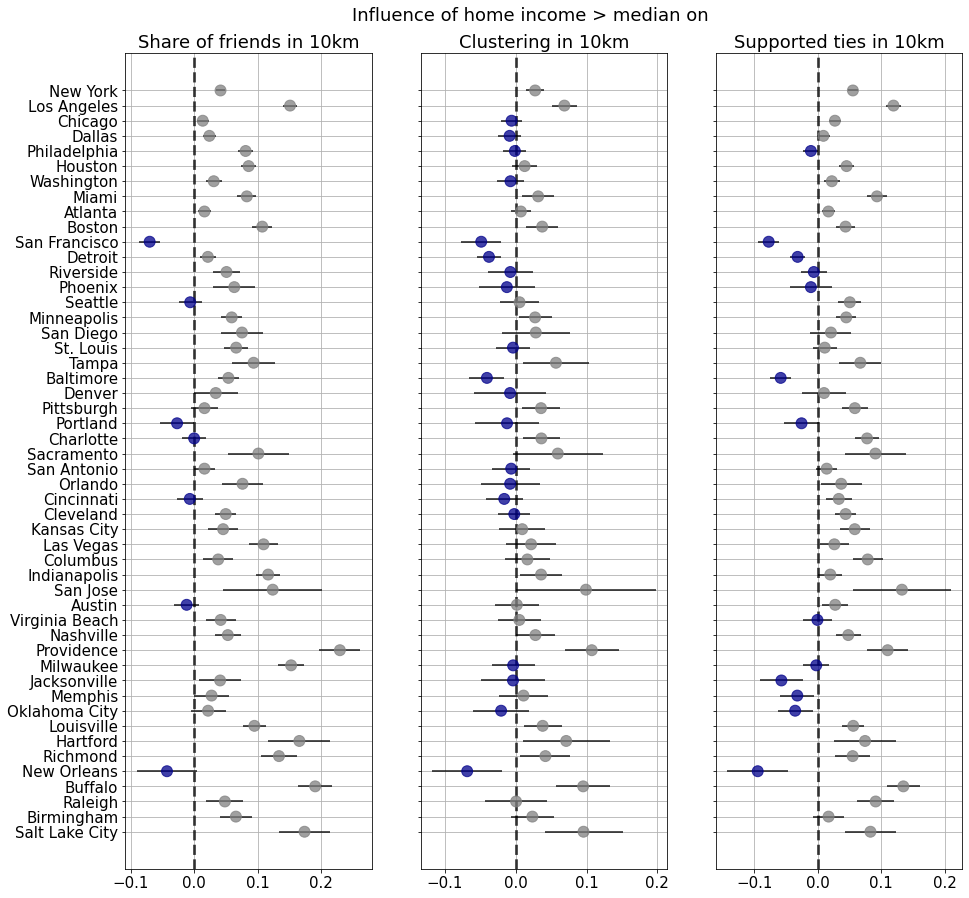

In [98]:
# plot
fig,ax = plt.subplots(1,3,figsize=(15,15), sharey=True)
plt.rcParams['font.size']=15

ax[0].scatter(plotdata['icoeff_deg'], plotdata['short_name'], color=plotdata["col_deg"], marker='o', s=120, alpha=0.75, zorder=3)
ax[0].hlines(xmin=(plotdata['icoeff_deg']-(1.96*plotdata['ise_clust'])), xmax=(plotdata['icoeff_deg']+(1.96*plotdata['ise_clust'])), y=plotdata['short_name'], color='black', alpha=0.9)
ax[0].axvline(linewidth=2.75, color='black', alpha=0.75, linestyle='dashed', zorder=2)
#ax[0].set_xlim([-0.775, 0.275])
ax[0].grid()
ax[0].set_title("Share of friends in 10km")

ax[1].scatter(plotdata['icoeff_clust'], plotdata['short_name'], color=plotdata["col_clust"], marker='o', s=120, alpha=0.75, zorder=3)
ax[1].hlines(xmin=(plotdata['icoeff_clust']-(1.96*plotdata['ise_deg'])), xmax=(plotdata['icoeff_clust']+(1.96*plotdata['ise_deg'])), y=plotdata['short_name'], color='black', alpha=0.9)
ax[1].axvline(linewidth=2.75, color='black', alpha=0.75, linestyle='dashed', zorder=2)
#ax[1].set_xlim([-0.775, 0.275])
ax[1].grid()
ax[1].set_title("Clustering in 10km")

ax[2].scatter(plotdata['icoeff_supp'], plotdata['short_name'], color=plotdata["col_supp"], marker='o', s=120, alpha=0.75, zorder=3)
ax[2].hlines(xmin=(plotdata['icoeff_supp']-(1.96*plotdata['ise_supp'])), xmax=(plotdata['icoeff_supp']+(1.96*plotdata['ise_supp'])), y=plotdata['short_name'], color='black', alpha=0.9)
ax[2].axvline(linewidth=2.75, color='black', alpha=0.75, linestyle='dashed', zorder=2)
#ax[2].set_xlim([-0.775, 0.275])
ax[2].grid()
ax[2].set_title("Supported ties in 10km")

fig.text(0.5, 0.91, 'Influence of home income > median on', ha='center', size=18)

plt.show()
# plt.savefig('../fig/mf4.png',density=300,bbox_inches='tight')

## Fig5 - income distribution of friends

In [2]:
# edgelist with income data
edge_table = pd.read_csv("../data/edgelist_tractinfo.csv.gz")

# dist manipulation
edge_table["dist_hh"] = edge_table["dist_hh"].astype(int)
edge_table = edge_table[edge_table["income2"]>1000]

In [3]:
edge_table.head()

,cbsacode,short_name,user_id1,user_id2,dist_hh,tract_id1,population1,education_bachelor1,income1,income_median1,poor1,tract_id2,population2,education_bachelor2,income2,income_median2,poor2
0,41860.0,San Francisco,21,18,24954,14000US06075017601,6706.0,1198.0,28153.0,37892.0,1.0,14000US06041121100,5126.0,1574.0,66249.0,37892.0,0.0
1,41860.0,San Francisco,21,3476,3071,14000US06075017601,6706.0,1198.0,28153.0,37892.0,1.0,14000US06075010200,4040.0,1520.0,92980.0,37892.0,0.0
2,41860.0,San Francisco,21,3922,3122,14000US06075017601,6706.0,1198.0,28153.0,37892.0,1.0,14000US06075020800,6470.0,1246.0,35419.0,37892.0,1.0
3,41860.0,San Francisco,21,3936,17065,14000US06075017601,6706.0,1198.0,28153.0,37892.0,1.0,14000US06001403400,4577.0,1105.0,38154.0,37892.0,0.0
4,41860.0,San Francisco,21,12193,3931,14000US06075017601,6706.0,1198.0,28153.0,37892.0,1.0,14000US06075020900,4944.0,1145.0,32177.0,37892.0,1.0


In [4]:
# data for the density plots
dist10 = edge_table[edge_table["dist_hh"]<=10000]
dist5 = edge_table[edge_table["dist_hh"]<=5000]
dist1 = edge_table[edge_table["dist_hh"]<=1000]

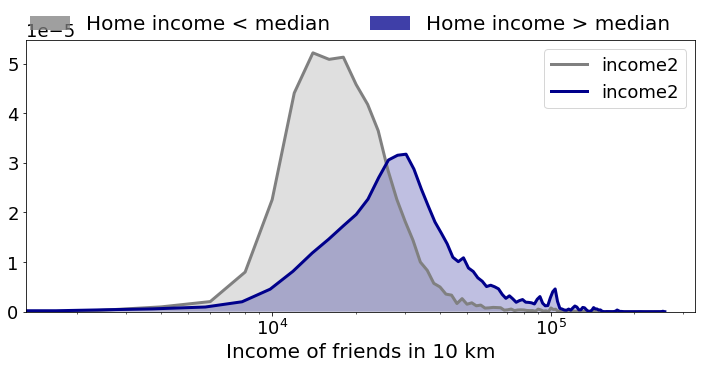

In [13]:
# density
plt.rcParams['font.size'] = 18
fig,ax = plt.subplots(1,1, figsize=(12,5))

ax = sns.kdeplot(dist10[dist10["poor1"]==1]["income2"], color="grey", linewidth=3, shade = True )
ax = sns.kdeplot(dist10[dist10["poor1"]==0]["income2"], color="darkblue", linewidth=3, shade = True)

#, log_scale=True, fill=True

# set axis info
ax.set_xlabel("Income of friends in 10 km", size=20)

# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1),
    ncol=2, frameon=False, fontsize=20)

plt.xscale('log')

plt.show()
# plt.savefig('../fig/mf5.png',density=300,bbox_inches='tight')

<ipython-input-29-05737224e071>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/mf5.png',density=300,bbox_inches='tight')


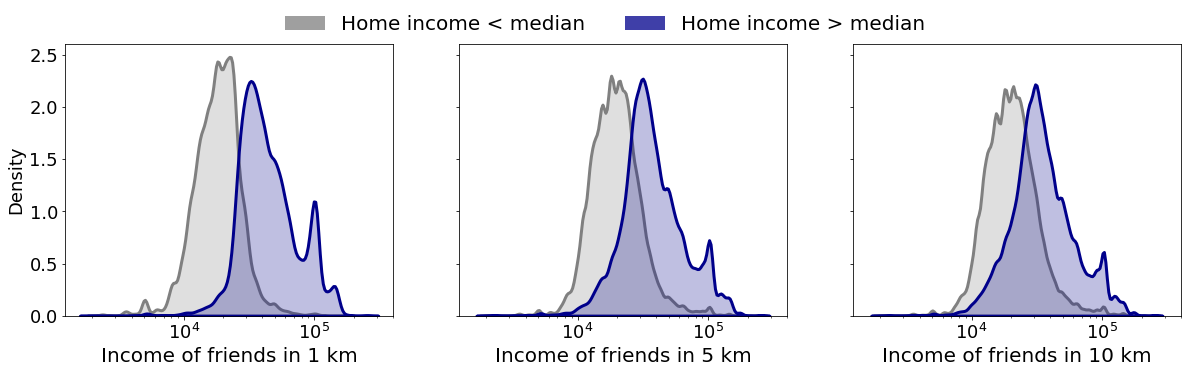

In [29]:
# density
plt.rcParams['font.size'] = 18
fig,ax = plt.subplots(1,3, figsize=(20,5), sharey=True, sharex=True)

sns.kdeplot(dist1[dist1["poor1"]==1]["income2"], ax=ax[0], log_scale=True, fill=True, color="grey", linewidth=3)
sns.kdeplot(dist1[dist1["poor1"]==0]["income2"], ax=ax[0], log_scale=True, fill=True, color="darkblue", linewidth=3)
ax[0].set_xlabel("Income of friends in 1 km", size=20)

sns.kdeplot(dist5[dist5["poor1"]==1]["income2"], ax=ax[1], log_scale=True, fill=True, color="grey", linewidth=3)
sns.kdeplot(dist5[dist5["poor1"]==0]["income2"], ax=ax[1], log_scale=True, fill=True, color="darkblue", linewidth=3)
ax[1].set_xlabel("Income of friends in 5 km", size=20)

sns.kdeplot(dist10[dist10["poor1"]==1]["income2"], ax=ax[2], log_scale=True, fill=True, color="grey", linewidth=3)
sns.kdeplot(dist10[dist10["poor1"]==0]["income2"], ax=ax[2], log_scale=True, fill=True, color="darkblue", linewidth=3)
ax[2].set_xlabel("Income of friends in 10 km", size=20)


# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.01),
    ncol=2, frameon=False, fontsize=20)

# plt.savefig('../fig/mf5.png',density=300,bbox_inches='tight')
plt.show()

## Fig5 alternative - income distribution of friends

In [2]:
# edgelist with income data
edge_table = pd.read_csv("../data/edgelist_tractinfo.csv.gz")

# degree data
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz").set_index('user_id')

In [3]:
# create nr poor ties var
temp = edge_table[edge_table["poor2"]==1]
degree_tab["poor_ties"] = degree_tab.index.map(temp.groupby("user_id1")["user_id2"].agg("count").to_dict())
degree_tab = degree_tab.reset_index()

In [4]:
# share of poor/rich ties
degree_tab["share_poor_ties"] = degree_tab["poor_ties"] / degree_tab["degree"]
degree_tab["share_rich_ties"] = 1 - (degree_tab["poor_ties"] / degree_tab["degree"])

In [5]:
print("share of poor ties for poor :", degree_tab[degree_tab["poor"]==1]["share_poor_ties"].mean())
print("share of poor ties for rich :", degree_tab[degree_tab["poor"]==1]["share_rich_ties"].mean())

share of poor ties for poor : 0.7094604613926779
share of poor ties for rich : 0.290539538607322


In [6]:
print("share of rich ties for poor :", degree_tab[degree_tab["poor"]==0]["share_poor_ties"].mean())
print("share of rich ties for rich :", degree_tab[degree_tab["poor"]==0]["share_rich_ties"].mean())

share of rich ties for poor : 0.4143739108366776
share of rich ties for rich : 0.5856260891633224


In [7]:
pp = np.round(degree_tab[degree_tab["poor"]==1]["share_poor_ties"].mean(),2)
pr = np.round(degree_tab[degree_tab["poor"]==1]["share_rich_ties"].mean(),2)
rp = np.round(degree_tab[degree_tab["poor"]==0]["share_poor_ties"].mean(),2)
rr = np.round(degree_tab[degree_tab["poor"]==0]["share_rich_ties"].mean(),2)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later


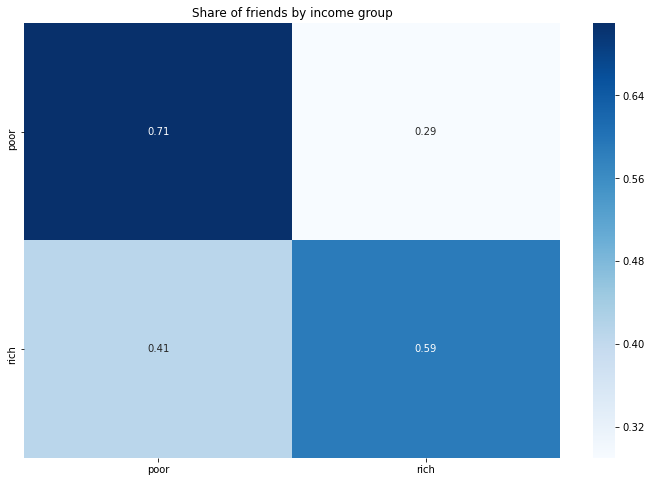

In [8]:
fig,ax = plt.subplots(1,1, figsize=(12,8))

l1 = [pp, pr, rp, rr]

columns = 2
rows    = 2

# Create a 2x2 ndarray
grid         = np.ndarray((2, 2));
listIndex    = 0;

# Fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l1[listIndex];
        listIndex = listIndex+1;

# Create a heatmap and display
sns.heatmap(grid, annot=True, fmt="g", cmap="Blues", xticklabels = ["poor", "rich"], yticklabels = ["poor", "rich"], ax = ax)

ax.set_title('Share of friends by income group')

plt.savefig('../fig/heat1.png',density=300,bbox_inches='tight')

In [9]:
pr_ties = pd.read_csv("../data/pr_friends_stats.csv.gz")

In [10]:
pr_ties.head()

,user_id,cbsacode,short_name,poor,degree,poor_ties,share_poor_ties,share_rich_ties,clust_poor,clust_rich,support_poor,support_rich
0,21,41860.0,San Francisco,1.0,49,9.0,0.183673,0.816327,0.068662,0.150685,0.777778,0.833333
1,47,35620.0,New York,0.0,59,9.0,0.152542,0.847458,0.008639,0.363069,0.555556,0.840909
2,293,41860.0,San Francisco,1.0,10,2.0,0.200000,0.800000,0.078947,0.209302,1.000000,0.714286
3,294,42660.0,Seattle,0.0,11,NaN,NaN,NaN,NaN,0.100000,NaN,0.250000
4,364,14460.0,Boston,0.0,29,3.0,0.103448,0.896552,0.000000,0.482927,0.000000,0.937500


In [11]:
pp_c = np.round(pr_ties[pr_ties["poor"]==1]["clust_poor"].mean(),2)
pr_c = np.round(pr_ties[pr_ties["poor"]==1]["clust_rich"].mean(),2)
rp_c = np.round(pr_ties[pr_ties["poor"]==0]["clust_poor"].mean(),2)
rr_c = np.round(pr_ties[pr_ties["poor"]==0]["clust_rich"].mean(),2)

Text(0.5, 1.0, 'Clustering by income group')

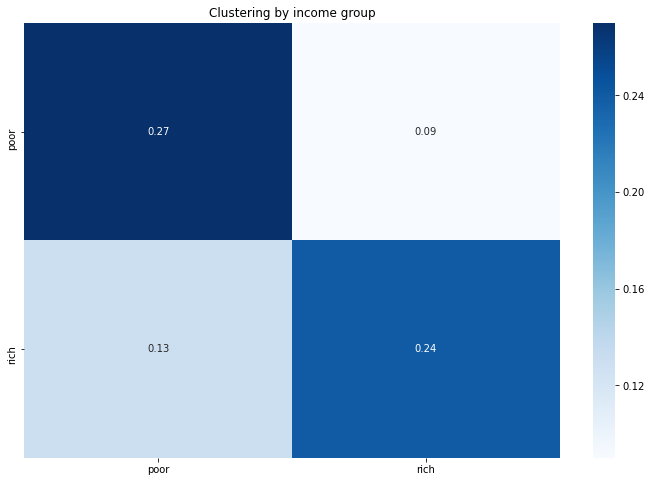

In [12]:
fig,ax = plt.subplots(1,1, figsize=(12,8))

l1 = [pp_c, pr_c, rp_c, rr_c]

columns = 2
rows    = 2

# Create a 2x2 ndarray
grid         = np.ndarray((2, 2));
listIndex    = 0;

# Fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l1[listIndex];
        listIndex = listIndex+1;

# Create a heatmap and display
sns.heatmap(grid, annot=True, fmt="g", cmap="Blues", xticklabels = ["poor", "rich"], yticklabels = ["poor", "rich"], ax = ax)

ax.set_title('Clustering by income group')

#plt.savefig('../fig/heat2.png',density=300,bbox_inches='tight')

In [12]:
pp_s = np.round(pr_ties[pr_ties["poor"]==1]["support_poor"].mean(),2)
pr_s = np.round(pr_ties[pr_ties["poor"]==1]["support_rich"].mean(),2)
rp_s = np.round(pr_ties[pr_ties["poor"]==0]["support_poor"].mean(),2)
rr_s = np.round(pr_ties[pr_ties["poor"]==0]["support_rich"].mean(),2)

Text(0.5, 1.0, 'Support by income group')

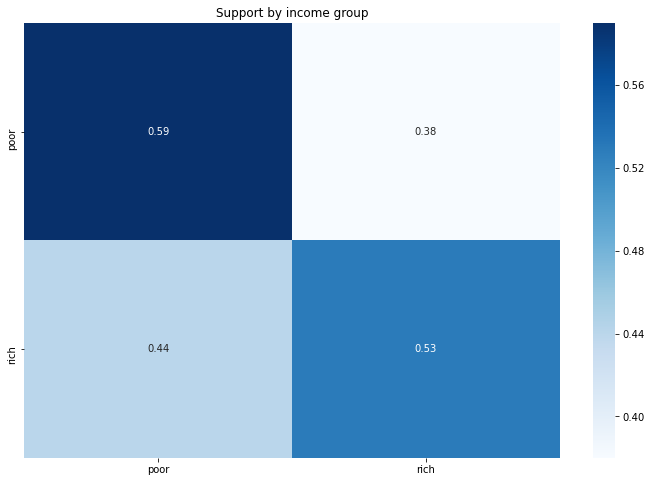

In [17]:
fig,ax = plt.subplots(1,1, figsize=(12,8))

l1 = [pp_s, pr_s, rp_s, rr_s]

columns = 2
rows    = 2

# Create a 2x2 ndarray
grid         = np.ndarray((2, 2));
listIndex    = 0;

# Fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l1[listIndex];
        listIndex = listIndex+1;

# Create a heatmap and display
sns.heatmap(grid, annot=True, fmt="g", cmap="Blues", xticklabels = ["poor", "rich"], yticklabels = ["poor", "rich"], ax = ax)

ax.set_title('Support by income group')

#plt.savefig('../fig/heat3.png',density=300,bbox_inches='tight')

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later


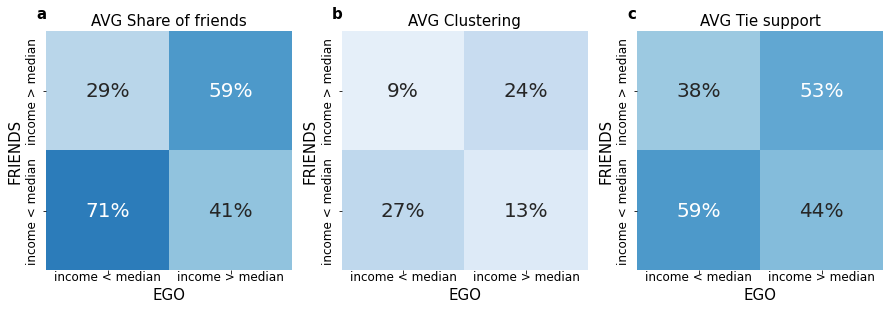

In [29]:
#fig,ax = plt.subplots(1,3, figsize=(24,7))

fig,ax = plt.subplots(1,3, figsize=(15,4.4))

l1 = [pr*100, rr*100, pp*100, rp*100]

columns = 2
rows    = 2

# Create a 2x2 ndarray
grid         = np.ndarray((2, 2));
listIndex    = 0;

# Fill in the 2x2 ndarray
for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l1[listIndex];
        listIndex = listIndex+1;
        
# horizontal position, vertical position, width, height
#cbar_ax = fig.add_axes([.25, -0.03, .5, .02])

# Create a heatmap and display
g = sns.heatmap(grid, annot=True,annot_kws={"fontsize":20}, fmt="g", xticklabels = ["income < median", "income > median"], yticklabels = ["income > median", "income < median"],vmin=0, vmax=100, cmap="Blues", ax = ax[0], cbar=False)

#, cbar_kws = dict(orientation="horizontal"),cbar=True,cbar_ax=cbar_ax, vmin=0, vmax=1

g.set_yticklabels(labels=g.get_yticklabels(), va='center', size = 12)

g.set_xticklabels(labels=g.get_xticklabels(), va='center', size = 12)

g.set_xlabel("EGO", size = 15)

g.set_ylabel("FRIENDS", size = 15)

ax[0].set_title('AVG Share of friends', size = 15)

for t in g.texts: t.set_text(t.get_text() + "%")

grid         = np.ndarray((2, 2));
listIndex    = 0;

l2 = [pr_c*100, rr_c*100, pp_c*100, rp_c*100]

for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l2[listIndex];
        listIndex = listIndex+1;

# Create a heatmap and display
h = sns.heatmap(grid, annot=True, fmt="g", cmap="Blues", xticklabels = ["income < median", "income > median"], yticklabels = ["income > median", "income < median"], ax = ax[1],vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":20})

h.set_yticklabels(labels=h.get_yticklabels(), va='center', size = 12)

h.set_xticklabels(labels=h.get_xticklabels(), va='center', size = 12)

h.set_xlabel("EGO", size = 15)

h.set_ylabel("FRIENDS", size = 15)

ax[1].set_title('AVG Clustering', size = 15)

for t in h.texts: t.set_text(t.get_text() + "%")

grid         = np.ndarray((2, 2));
listIndex    = 0;

l3 = [pr_s*100, rr_s*100, pp_s*100, rp_s*100]

for i in range(0, rows):
    for j in range(0, columns):
        grid[i][j] = l3[listIndex];
        listIndex = listIndex+1;

# Create a heatmap and display
i = sns.heatmap(grid, annot=True, fmt="g", cmap="Blues", xticklabels = ["income < median", "income > median"], yticklabels = ["income > median", "income < median"], ax = ax[2], cbar=False, vmin=0, vmax=100, annot_kws={"fontsize":20})

i.set_yticklabels(labels = i.get_yticklabels(), va='center', size = 12)

i.set_xticklabels(labels = i.get_xticklabels(), va='center', size = 12)

i.set_xlabel("EGO", size = 15)

i.set_ylabel("FRIENDS", size = 15)

ax[2].set_title('AVG Tie support', size = 15)

for t in i.texts: t.set_text(t.get_text() + "%")

#plt.annotate('AVG values', [0.47, 1.04])

#plt.annotate('AVG values', [0, 1.04])

for a, label in zip(ax, ['A','B','C','D','E','F','G','H']):
    a.annotate(label.lower(), xy=(0,1), xycoords='axes fraction', xytext=(-10,12.5),textcoords='offset pixels', weight='bold', size = 15)

plt.savefig('../fig/mf5.png',density=300,bbox_inches='tight')

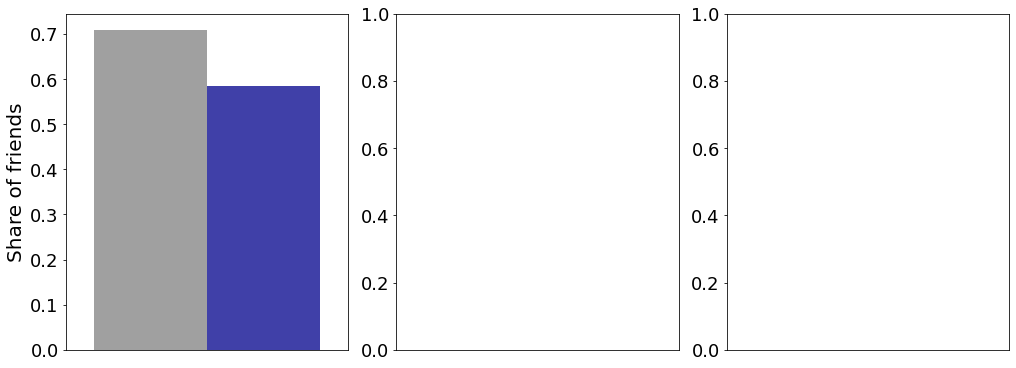

In [26]:
# plot figure 5 new -?-
fig, ax = plt.subplots(1, 3, figsize = (14, 5), constrained_layout=True, sharex=True)
plt.rcParams['font.size']=18

# color of bars
colorsList = ["grey", "darkblue"]

X = [0.4, 0.6]
bar_width = 0.2
pp_bar = degree_tab[degree_tab["poor"]==1]["share_poor_ties"].mean()
rr_bar = degree_tab[degree_tab["poor"]==0]["share_rich_ties"].mean()
bar1 = ax[0].bar(X[0], pp_bar, color = colorsList[0], width = bar_width, label = 'Poor users', alpha=0.75)
bar2 = ax[0].bar(X[1], rr_bar, color = colorsList[1], width = bar_width, label = 'Poor users', alpha=0.75)

ax[0].set_ylabel('Share of friends', size=20)
ax[0].set_xticks([])
ax[0].set_xlim([0.25,0.75])
#ax[0].set_xticks(X + bar_width/2)
#ax[0].set_xticklabels(['1 km', '5 km', '10 km'])
#ax[0].set_ylim([0, 0.205])

plt.show()

In [13]:
X

array([0, 1])

In [9]:
poor_bar = degree_tab[degree_tab["poor"]==1]["share_poor_ties"].mean()
poor_bar

0.7094604613926779

In [126]:
# data for Fig2b

# add new columns
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]

# share of ties at distance
for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]

# replace NA with 0
degree_tab = degree_tab.fillna(0)

# poor-rich means
pr = {"poor" : 1, "rich" : 0}

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# loop to construct the dataframe
for t in pr:
    
    # name the necessary columns
    col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # loop for variables
    for c in list(temp.columns):
        rownames.append(str(c))
        means.append(np.mean(temp[str(c)]))

fig_b = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

<ipython-input-132-29b177443f9b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


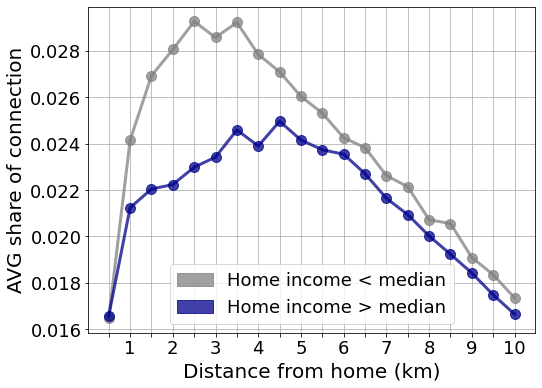

In [132]:
# parameters of chart
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))

home_poor = ax.plot(fig_b["dist"][:20], fig_b[fig_b["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
home_rich = ax.plot(fig_b["dist"][20:], fig_b[fig_b["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax.set_xticklabels(labels)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)

home_patch = mpatches.Patch(color='grey', label='Home income < median', alpha=0.75)
work_patch = mpatches.Patch(color='darkblue', label='Home income > median', alpha=0.75)
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from home (km)", size=20)
ax.set_ylabel("AVG share of connection",  size=20)
ax.grid()

plt.show()

In [206]:
# data for Fig2c

rownames = []
means = []
type = list(["poor"] *20) + list(["rich"] *20)

# name the necessary columns
col_filter = ['d500','d1000', 'd1500','d2000', 'd2500','d3000', 'd3500','d4000',  'd4500', 'd5000',
    'd5500','d6000', 'd6500', 'd7000', 'd7500', 'd8000', 'd8500', 'd9000', 'd9500', 'd10000']

# loop to construct the dataframe
for t in pr:
    
    # table and columns to use
    temp = degree_tab[degree_tab["poor"]==pr[t]]
    temp = temp.loc[:, temp.columns.isin(col_filter)]

    # multiplicator - to get the additional area of concentric circles/rings (r2*pi -- 1,4,9,16..)
    x = np.linspace(1,39,20)

    # loop for variables
    for idx, c in enumerate(list(temp.columns)):
        rownames.append(str(c))
        means.append((np.mean(temp[str(c)]) * 1/x[idx]) * 1/(0.25*np.pi))   # area of the circle defined in the baseline 0.5*0.5*pi area
        
fig_c = pd.DataFrame({ 'dist': rownames , 'mean': means, 'type': type})

<ipython-input-207-4bb4bd15c2e0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


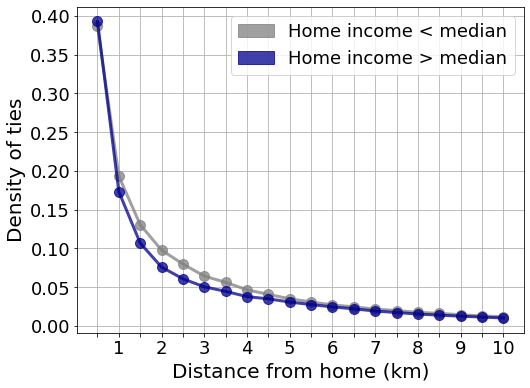

In [207]:
# 
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)
plt.rcParams['font.size']=18

labels = list((np.linspace(0.5,10,20)).astype(int))

home_poor = ax.plot(fig_c["dist"][:20], fig_c[fig_c["type"]=="poor"]["mean"], "o-", color="grey", linewidth=3, markersize=10, alpha=0.75)
home_rich = ax.plot(fig_c["dist"][20:], fig_c[fig_c["type"]=="rich"]["mean"], "o-", color="darkblue", linewidth=3, markersize=10, alpha=0.75)
ax.set_xticklabels(labels)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)

home_patch = mpatches.Patch(color='grey', label='Home income < median', alpha=0.75)
work_patch = mpatches.Patch(color='darkblue', label='Home income > median', alpha=0.75)
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from home (km)", size=20)
ax.set_ylabel("Density of ties",  size=20)
ax.grid()

plt.show()

In [201]:
degree_tab.columns

Index(['user_id', 'cbsacode', 'short_name', 'poor', 'lat_home', 'lon_home',
       'degree', 'd500', 'd1000', 'd1500', 'd2000', 'd2500', 'd3000', 'd3500',
       'd4000', 'd4500', 'd5000', 'd5500', 'd6000', 'd6500', 'd7000', 'd7500',
       'd8000', 'd8500', 'd9000', 'd9500', 'd10000', 'dcum500', 'dcum1000',
       'dcum1500', 'dcum2000', 'dcum2500', 'dcum3000', 'dcum3500', 'dcum4000',
       'dcum4500', 'dcum5000', 'dcum5500', 'dcum6000', 'dcum6500', 'dcum7000',
       'dcum7500', 'dcum8000', 'dcum8500', 'dcum9000', 'dcum9500', 'dcum10000',
       'dcum500_share', 'dcum1000_share', 'dcum1500_share', 'dcum2000_share',
       'dcum2500_share', 'dcum3000_share', 'dcum3500_share', 'dcum4000_share',
       'dcum4500_share', 'dcum5000_share', 'dcum5500_share', 'dcum6000_share',
       'dcum6500_share', 'dcum7000_share', 'dcum7500_share', 'dcum8000_share',
       'dcum8500_share', 'dcum9000_share', 'dcum9500_share',
       'dcum10000_share'],
      dtype='object')

In [ ]:
# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

Bootstrapping via https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d

In [4]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

## avg share 1/5/10 plots

In [40]:
# run the above part until plotdata

# means
poor_means = [result_poor["mean"][1], result_poor['mean'][9], result_poor['mean'][19]]
rich_means = [result_rich["mean"][1], result_rich['mean'][9], result_rich['mean'][19]]

# errors
poor_error_lower = [result_poor['error_lower'][1], result_poor['error_lower'][9], result_poor['error_lower'][19]]
poor_error_upper = [result_poor['error_upper'][1], result_poor['error_upper'][9], result_poor['error_upper'][19]]
rich_error_lower = [result_rich['error_lower'][1], result_rich['error_lower'][9], result_rich['error_lower'][19]]
rich_error_upper = [result_rich['error_upper'][1], result_rich['error_upper'][9], result_rich['error_upper'][19]]

<ipython-input-44-1c9850fad4e6>:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig3.png',density=300,bbox_inches='tight')


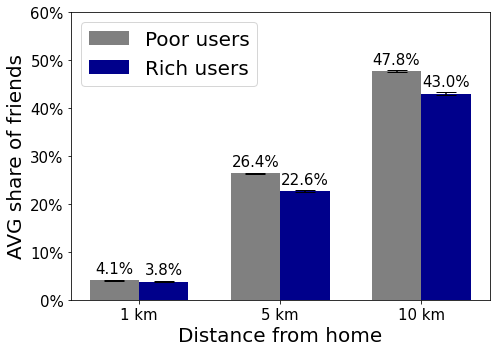

In [44]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']
                                                                                                                    
# color of bars
colorsList = ["grey", "darkblue"]

# bars
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, poor_means, color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [poor_error_lower, poor_error_upper], capsize = 10)
rects2 = ax.bar(X + bar_width, rich_means, color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [rich_error_lower, rich_error_upper], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 20, loc="upper left") # edgecolor = 'black'
ax.set(ylabel='AVG share of friends')
ax.set(xlabel='Distance from home')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.6])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
# plt.savefig('../fig/fig3.png',density=300,bbox_inches='tight')

## change in share of friends

In [45]:
# reopen degree_tab
degree_tab = pd.read_csv("../data/degree_tab_top50.csv.gz")

In [46]:
# add new columns
col_list = ["d500", "d1000", "d1500", "d2000", "d2500", "d3000", "d3500", "d4000", "d4500", "d5000", "d5500", "d6000", "d6500", "d7000", "d7500", "d8000", "d8500", "d9000", "d9500", "d10000"]

for c in list(col_list):
    degree_tab[str(c) + "_share"] = degree_tab[str(c)] / degree_tab["degree"]

# replace NA with 0
degree_tab = degree_tab.fillna(0)

In [47]:
# create poor / rich groups
degree_rich = degree_tab[degree_tab['poor'] == 0]
degree_poor = degree_tab[degree_tab['poor'] == 1]

In [48]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [49]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

# type plot
type = ["poor"] * 20

# table and columns to use
temp = degree_poor.loc[:, degree_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [50]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# name the necessary columns
col_filter = ['d500_share','d1000_share', 'd1500_share','d2000_share', 'd2500_share','d3000_share', 'd3500_share','d4000_share',  'd4500_share', 'd5000_share', 'd5500_share','d6000_share', 'd6500_share', 'd7000_share', 'd7500_share', 'd8000_share', 'd8500_share', 'd9000_share', 'd9500_share', 'd10000_share']

# type plot
type = ["rich"] * 20

# table and columns to use
temp = degree_rich.loc[:, degree_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)], np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type, 'distance': annotations})

In [53]:
# combine
plotdata = pd.concat([result_poor, result_rich])

<ipython-input-61-9548233e863b>:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig4.png',density=300,bbox_inches='tight')


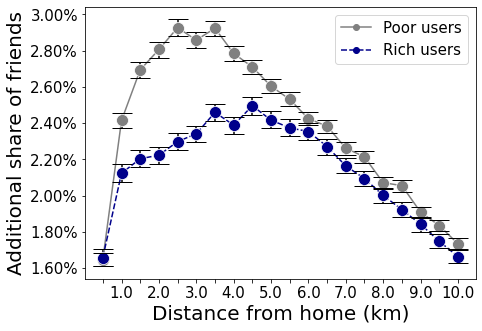

In [61]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

# colors of lines
colorsList = ["grey", "darkblue"]

# lineplot created
ax = sns.lineplot(data = plotdata, x = 'distance', y = 'mean', hue = 'type', style = 'type', palette = colorsList, dashes=True, ax = ax, markers=["o", "o"], markersize = 12)

ax.errorbar(data = plotdata, x = 'distance', y = 'mean', yerr= [plotdata['error_lower'], plotdata['error_upper']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=['Poor users', 'Rich users'], fontsize = 15)
ax.set(xlabel='Distance from home (km)', ylabel='Additional share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
# ax.set_title('$\Delta$ Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.savefig('../fig/fig4.png',density=300,bbox_inches='tight')

## clustering around HOME

In [3]:
# clustering table
clust_table = pd.read_csv("../data/clust_tab_top50.csv.gz")

# poor / rich info
user_info = pd.read_csv("../data/degree_tab_top50.csv.gz")
user_info = user_info[["user_id", "cbsacode", "short_name", "poor"]]

In [4]:
# add poor / rich info
clust_table = pd.merge(clust_table, user_info, on="user_id", how="left")

In [5]:
# create poor / rich groups
clust_rich = clust_table[clust_table['poor'] == 0]
clust_poor = clust_table[clust_table['poor'] == 1]

In [6]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [7]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["poor"] * 3

# name the necessary columns
col_filter = ['clust1000','clust5000', 'clust10000']

# table and columns to use
temp = clust_poor.loc[:, clust_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [8]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["rich"] * 3

# name the necessary columns
col_filter = ['clust1000','clust5000', 'clust10000']

# table and columns to use
temp = clust_rich.loc[:, clust_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [9]:
# combine
cluster_plot = pd.concat([result_poor, result_rich])

<ipython-input-19-7a6d4792e2cd>:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig5.png',density=300,bbox_inches='tight')


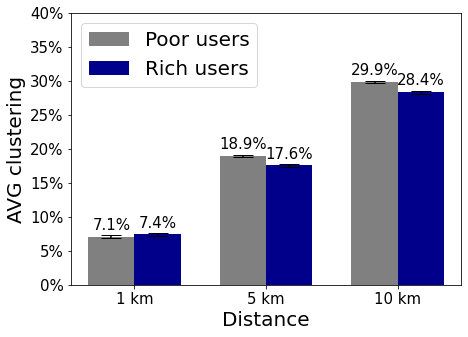

In [19]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']

# colors of bars
colorsList = ["grey", "darkblue"]

# bar plot creation
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, cluster_plot[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users',
    yerr = [cluster_plot[0:3]['error_lower'], cluster_plot[0:3]['error_upper']], capsize = 10)
rects2 = ax.bar(X + bar_width, cluster_plot[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users',
    yerr = [cluster_plot[3:]['error_lower'], cluster_plot[3:]['error_upper']], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 20, loc="upper left")
ax.set(ylabel='AVG clustering')
ax.set(xlabel='Distance')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.4])

# function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

#plt.tight_layout()
plt.savefig('../fig/fig5.png',density=300,bbox_inches='tight')
#plt.show()

## supported ties around HOME

In [20]:
# clustering table
supp_table = pd.read_csv("../data/supp_tab_top50.csv.gz")

# poor / rich info
user_info = pd.read_csv("../data/degree_tab_top50.csv.gz")
user_info = user_info[["user_id", "cbsacode", "short_name", "poor"]]

In [21]:
# add poor / rich info
supp_table = pd.merge(supp_table, user_info, on="user_id", how="left")

In [22]:
# create poor / rich groups
supp_rich = supp_table[supp_table['poor'] == 0]
supp_poor = supp_table[supp_table['poor'] == 1]

In [23]:
# bootstrap function
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # create bootstrap replicates as much as size
    for i in range(size):
        # create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [24]:
# construct a dataframe -poor- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["poor"] * 3

# name the necessary columns
col_filter = ['support1000','support5000', 'support10000']

# table and columns to use
temp = supp_poor.loc[:, supp_poor.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_poor = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [25]:
# construct a dataframe -rich- for figure
rownames = []
means = []
upper = []
lower = []
error_lower  = []
error_upper =[]

# type plot
type = ["rich"] * 3

# name the necessary columns
col_filter = ['support1000','support5000', 'support10000']

# table and columns to use
temp = supp_rich.loc[:, supp_rich.columns.isin(col_filter)]

# loop for variables
for c in list(temp.columns):
    rownames.append(str(c))
    bootstrap_mean = draw_bs_replicates(temp[str(c)].dropna(), np.mean, 2000)   # change repetition HERE
    means.append(np.mean(bootstrap_mean))
    lower.append(np.percentile(bootstrap_mean, 2.5))
    upper.append(np.percentile(bootstrap_mean, 97.5))
    error_lower.append((np.mean(bootstrap_mean) - np.percentile(bootstrap_mean, 2.5)))
    error_upper.append((np.percentile(bootstrap_mean, 97.5) - np.mean(bootstrap_mean)))
    
result_rich = pd.DataFrame({ 'dist': rownames , 'mean': means, 'error_lower': error_lower,'error_upper': error_upper, 'lower': lower, 'upper': upper, 'type': type})

In [26]:
# combine
support_plot = pd.concat([result_poor, result_rich])

<ipython-input-36-a29db8406416>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../fig/fig6.png',density=300,bbox_inches='tight')


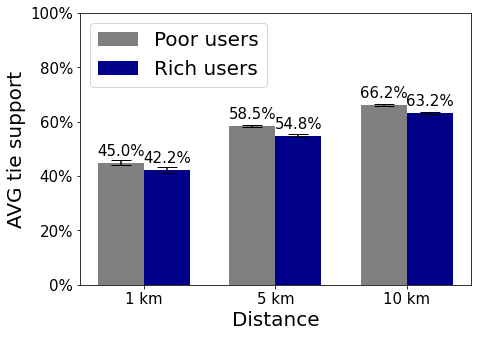

In [36]:
# parameters of chart
fig, ax = plt.subplots(1,1, figsize=(7, 5))

titles = ['1 km', '5 km', '10 km']

# colors of bars
colorsList = ["grey", "darkblue"]

# bar plot creation
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, support_plot[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users',
    yerr = [support_plot[0:3]['error_lower'], support_plot[0:3]['error_upper']], capsize = 10)

rects2 = ax.bar(X + bar_width, support_plot[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users',
    yerr = [support_plot[3:]['error_lower'], support_plot[3:]['error_upper']], capsize = 10) 

# customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 20, loc="upper left")
ax.set(ylabel='AVG tie support')
ax.set(xlabel='Distance')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 1])

# function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
autolabel(rects1)
autolabel(rects2)

#plt.tight_layout()
#plt.savefig('../figures/clustering_home_inc.jpg')
plt.savefig('../fig/fig6.png',density=300,bbox_inches='tight')
#plt.show()